## How does shuffling affect training performance?

A challenge with large datasets is shuffling data across space and time. Usually, large data are stored in chunks along the space and time coordinates. In this modality, a few shuffling strategies are possible.

 - No shuffling (easiest): data are sorted along each coordinate.
 - Chunk shuffling (medium): data are randomly sorted within each geographic chunk, but the overall chunks are in order.
 - Full shuffling (hardest): data are randomly distributed along each coordinate.

In this notebook, we test how these strategies affect the performance of a simple fully-connected model on the `ca_mort` dataset.

### 1. Get data

See [this notebook](https://github.com/s-kganz/ForestLST/blob/main/notebooks/get_drought_mortality.ipynb) for the provenance of these data.

In [4]:
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras
from sklearn.model_selection import train_test_split

In [3]:
ds = pd.read_csv("https://storage.googleapis.com/drought-table/preisler_dim_allyears.csv")
ds.drop(ds.columns[0], axis=1, inplace=True)
ds.head()

,elev,fire,latitude,longitude,mort,near,prcp,rhost,rwc,tmin,year
0,925.0,0.0,38.722502,-120.643743,0.0,0.0,1286.197498,0.999065,0.455582,-6.6150,1999
1,1072.0,0.0,38.722502,-120.607810,0.0,0.0,1317.052495,1.000000,0.455582,-6.9725,1999
2,1156.0,0.0,38.722502,-120.571877,0.0,0.0,1391.329998,1.000000,0.455582,-7.7800,1999
3,1146.0,0.0,38.722502,-120.535945,0.0,0.0,1383.149995,0.998043,0.455582,-8.1975,1999
4,1278.0,0.0,38.722502,-120.500012,0.0,0.0,1401.067500,0.997517,0.455582,-9.0075,1999


### 2. Train-validation split

It is easier to maintain a particular order if we do the train/validation split first.

In [7]:
ds_train, ds_valid = train_test_split(ds, test_size=0.3)

### 3. Do shuffling

In [16]:
# Simply sort on the coordinate variables
def no_shuffle(df: pd.DataFrame):
    return df.sort_values(["longitude", "latitude", "year"], ignore_index=True)

# Simply mush everything together
def full_shuffle(df: pd.DataFrame):
    return df.sample(frac=1, ignore_index=True)

# Less simply group observations in 2x2-degree blocks,
# shuffle within, then concat back together.
def chunk_shuffle(df: pd.DataFrame):
    df["chunk_id"] = ((np.floor(df["latitude"] / 2) * 2).astype(str) + 
                      (np.floor(df["longitude"] / 2) * 2).astype(str))
    
    df_chunks = [ch for _,ch in df.groupby("chunk_id")]
    random.shuffle(df_chunks)
    return pd.concat([ch.sample(frac=1) for ch in df_chunks])\
        .drop("chunk_id", axis=1)\
        .reset_index(drop=True)

train_noshuf = no_shuffle(ds_train)
valid_noshuf = no_shuffle(ds_valid)

train_fullshuf = full_shuffle(ds_train)
valid_fullshuf = full_shuffle(ds_valid)

train_chunkshuf = chunk_shuffle(ds_train)
valid_chunkshuf = chunk_shuffle(ds_valid)

We can verify shuffling happened as expected by plotting the index over space.

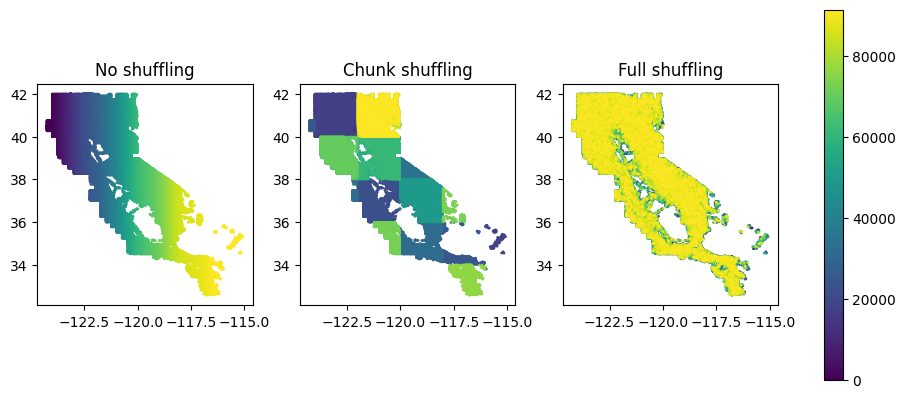

In [22]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(10, 4)

ax[0].scatter(valid_noshuf.longitude, valid_noshuf.latitude, c=valid_noshuf.index, s=1)
ax[0].set_title("No shuffling")
ax[0].set_aspect("equal")

ax[1].scatter(valid_chunkshuf.longitude, valid_chunkshuf.latitude, c=valid_chunkshuf.index, s=1)
ax[1].set_title("Chunk shuffling")
ax[1].set_aspect("equal")

im = ax[2].scatter(valid_fullshuf.longitude, valid_fullshuf.latitude, c=valid_fullshuf.index, s=1)
ax[2].set_title("Full shuffling")
ax[2].set_aspect("equal")

fig.tight_layout()
plt.colorbar(im, ax=ax, location="right")
plt.show()

### 4. Training

In [ ]:

TARGET = ["mort"]
BANDS   = ["fire", "near", "latitude", "longitude", "elev", "prcp", "rhost", "rwc", "tmin"]

REG  = keras.regularizers.L1(0.001)
DROP = 0.2
ACT  = "tanh"
BATCH_SIZE = 512

def df_to_tf_input(df):
    # Convert to numpy arrays 
    input = [
        df[b].to_numpy() for b in BANDS
    ]
    output = df[TARGET].to_numpy()
    
    return input, output

def build_model(init_bias=None):
    # Inputs
    inputs = [
        keras.layers.Input(shape=(1,), name=b) for b in BANDS
    ]

    concat = keras.layers.Concatenate(axis=-1)(inputs)

    # Normalize each band independently. 
    norm = keras.layers.BatchNormalization(axis=-1)(concat)

    # Feed normalized data to a few dense layers with dropout
    d1 = keras.layers.Dense(128, activation=ACT)(norm)
    drop1 = keras.layers.Dropout(DROP)(d1)
    d2 = keras.layers.Dense(16, activation=ACT)(drop1)
    drop2 = keras.layers.Dropout(DROP)(d2)
    d3 = keras.layers.Dense(8, activation=ACT)(drop2)

    # Connect to output.
    if init_bias is not None:
        init_bias = keras.initializers.Constant(init_bias)

    
    out_regr = keras.layers.Dense(
        1, activation="sigmoid", 
        name=TARGET[0],
        bias_initializer=init_bias
    )(d3)

    return keras.models.Model(inputs=inputs, outputs=out_regr)

# Calculate initial bias
init_bias = np.mean(ds_train.mort)

def do_training_run(train, valid):
    regr_metrics = [
        keras.metrics.RootMeanSquaredError(name="rmse"),
        keras.metrics.R2Score(name="r2_score")
    ]

    X_train, y_train = df_to_tf_input(train)
    X_valid, y_valid = df_to_tf_input(valid)

    model = build_model(init_bias=init_bias)
    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=0.005),
        metrics=regr_metrics
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        validation_data=(X_valid, y_valid),
        validation_batch_size=BATCH_SIZE,
        epochs=30,
        verbose=1,
        shuffle=False, # enforce order
    )

    return history


In [26]:
print("\t\t -- No shuffling --")
hist_noshuf = do_training_run(train_noshuf, valid_noshuf)

print("\t\t -- Full shuffling --")
hist_fullshuf = do_training_run(train_fullshuf, valid_fullshuf)

print("\t\t -- Chunked shuffling --")
hist_chunkshuf = do_training_run(train_chunkshuf, valid_chunkshuf)

		 -- No shuffling --
Epoch 1/30


c:\Users\rsgal\miniforge3\envs\forest_mort\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['fire', 'near', 'latitude', 'longitude', 'elev', 'prcp', 'rhost', 'rwc', 'tmin']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*', '*', '*', '*')
  warnings.warn(


418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0282 - r2_score: -36.2702 - rmse: 0.1509 - val_loss: 0.0138 - val_r2_score: -0.1105 - val_rmse: 0.1173
Epoch 2/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - r2_score: 0.3747 - rmse: 0.0564 - val_loss: 0.1292 - val_r2_score: -9.4333 - val_rmse: 0.3595
Epoch 3/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031 - r2_score: 0.4011 - rmse: 0.0547 - val_loss: 0.1450 - val_r2_score: -10.7049 - val_rmse: 0.3807
Epoch 4/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031 - r2_score: 0.4203 - rmse: 0.0549 - val_loss: 0.1419 - val_r2_score: -10.4604 - val_rmse: 0.3767
Epoch 5/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031 - r2_score: 0.4061 - rmse: 0.0547 - val_loss: 0.1454 - val_r2_score: -10.7394 - val_rmse: 0.3813
Epoch 6/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031 - r2_score: 0.3778 - rmse: 0.0553 - val_loss: 0.1449 - val_r2_score: -10.7023 - val_rmse: 0.3807
Epoch 7/30
418/418 ━━━━━━━━

c:\Users\rsgal\miniforge3\envs\forest_mort\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['fire', 'near', 'latitude', 'longitude', 'elev', 'prcp', 'rhost', 'rwc', 'tmin']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*', '*', '*', '*')
  warnings.warn(


418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0244 - r2_score: -0.9597 - rmse: 0.1413 - val_loss: 0.0032 - val_r2_score: 0.7401 - val_rmse: 0.0567
Epoch 2/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0038 - r2_score: 0.6975 - rmse: 0.0613 - val_loss: 0.0026 - val_r2_score: 0.7885 - val_rmse: 0.0512
Epoch 3/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - r2_score: 0.7443 - rmse: 0.0563 - val_loss: 0.0022 - val_r2_score: 0.8253 - val_rmse: 0.0465
Epoch 4/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - r2_score: 0.7786 - rmse: 0.0524 - val_loss: 0.0022 - val_r2_score: 0.8256 - val_rmse: 0.0465
Epoch 5/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - r2_score: 0.7902 - rmse: 0.0510 - val_loss: 0.0020 - val_r2_score: 0.8355 - val_rmse: 0.0451
Epoch 6/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - r2_score: 0.7992 - rmse: 0.0499 - val_loss: 0.0021 - val_r2_score: 0.8340 - val_rmse: 0.0453
Epoch 7/30
418/418 ━━━━━━━━━━━━━━━━━━━

c:\Users\rsgal\miniforge3\envs\forest_mort\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['fire', 'near', 'latitude', 'longitude', 'elev', 'prcp', 'rhost', 'rwc', 'tmin']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*', '*', '*', '*')
  warnings.warn(


418/418 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0233 - r2_score: -1.4493 - rmse: 0.1367 - val_loss: 0.0712 - val_r2_score: -4.7523 - val_rmse: 0.2669
Epoch 2/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - r2_score: 0.5751 - rmse: 0.0618 - val_loss: 0.0052 - val_r2_score: 0.5831 - val_rmse: 0.0718
Epoch 3/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037 - r2_score: 0.5957 - rmse: 0.0603 - val_loss: 0.0052 - val_r2_score: 0.5811 - val_rmse: 0.0720
Epoch 4/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036 - r2_score: 0.6016 - rmse: 0.0599 - val_loss: 0.0041 - val_r2_score: 0.6709 - val_rmse: 0.0638
Epoch 5/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - r2_score: 0.6202 - rmse: 0.0585 - val_loss: 0.0055 - val_r2_score: 0.5574 - val_rmse: 0.0740
Epoch 6/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - r2_score: 0.6196 - rmse: 0.0585 - val_loss: 0.0046 - val_r2_score: 0.6303 - val_rmse: 0.0677
Epoch 7/30
418/418 ━━━━━━━━━━━━━━━━━━

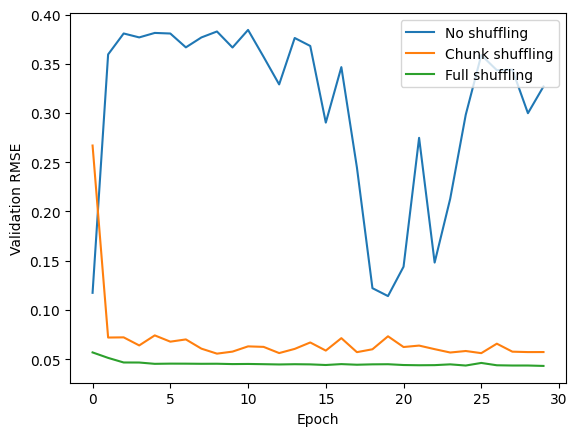

In [33]:
plt.plot(hist_noshuf.history["val_rmse"], label="No shuffling")
plt.plot(hist_chunkshuf.history["val_rmse"], label="Chunk shuffling")
plt.plot(hist_fullshuf.history["val_rmse"], label="Full shuffling")

plt.xlabel("Epoch")
plt.ylabel("Validation RMSE")
plt.legend(loc="upper right")
plt.show()